# Pima Indians Diabetes Multiclass Classification with Pytorch
In this workbook we will implement a ANN multi-class classifier to classify the Pima Diabetes dataset, which can be downloaded from [here]('https://raw.githubusercontent.com/a-coders-guide-to-ai/a-coders-guide-to-neural-networks/master/data/diabetes.csv').

In [519]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset

import pytorch_toolkit as pytk

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.10)

# Pytorch imports
print('Using Pytorch version: ', torch.__version__)

# seed all libraries for reproducibility
SEED = pytk.seed_all()

Using Pytorch version:  1.12.0+cpu


In [520]:

def load_or_download_dataset(force_download=False):
    url = r'https://raw.githubusercontent.com/a-coders-guide-to-ai/a-coders-guide-to-neural-networks/master/data/diabetes.csv'
    local_data_path = './data/diabetes.csv'

    if (not os.path.exists(local_data_path)) or force_download:
        print('Fetching data from URL...')
        df = pd.read_csv(url)
        df.to_csv(local_data_path)
    else:
        df = pd.read_csv(local_data_path, index_col=0)

    return df


In [521]:
df = load_or_download_dataset()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Some Analysis of the dataset

In [522]:
# any missing data?
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

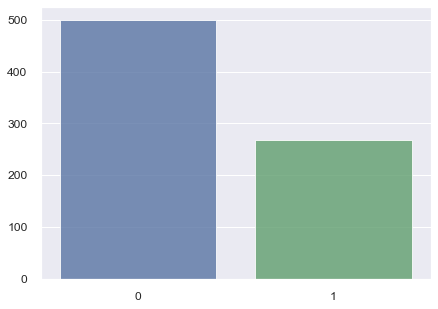

In [523]:
# how is the data (labels) distributed
outcomes = df['Outcome'].value_counts()
plt.figure(figsize=(7,5))
sns.barplot(outcomes.index, outcomes.values, alpha=0.8);

We can see that we have an imbalanced dataset, with positive count almost half that of the negative count.

Next, let's see how the features are distributes - we should have near normal distribution of all features.

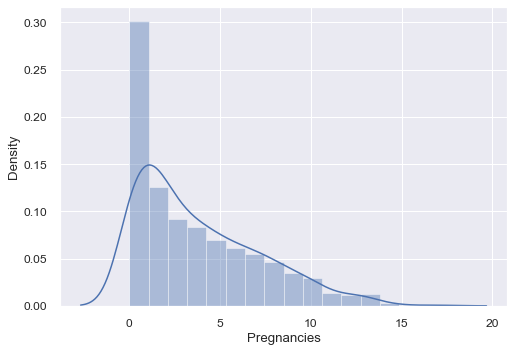

In [524]:
sns.distplot(df['Pregnancies']);

This is clearly left-skewed, with most cases having no pregnencies.

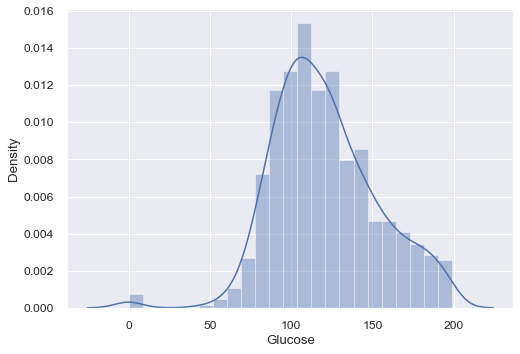

In [525]:
sns.distplot(df['Glucose']);

This is slightly left skewed, with amild right tail - and there seems to be 1 outlier!

In [526]:
df.loc[df.Glucose == 0,:]  # about 5 records

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


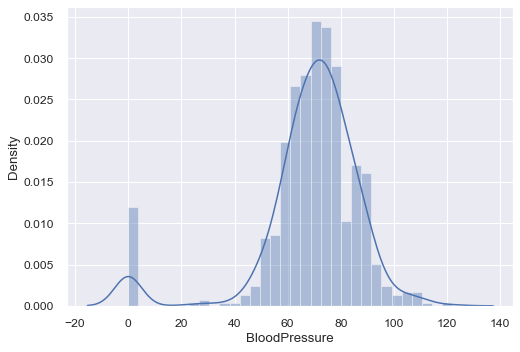

In [527]:
sns.distplot(df['BloodPressure']);

This is fairly normally distributes - there are some outliers with near zero BP!

In [528]:
df.loc[df.BloodPressure == 0,:]   # around 35 records!

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
172,2,87,0,23,0,28.9,0.773,25,0
193,11,135,0,0,0,52.3,0.578,40,1
222,7,119,0,0,0,25.2,0.209,37,0
261,3,141,0,0,0,30.0,0.761,27,1


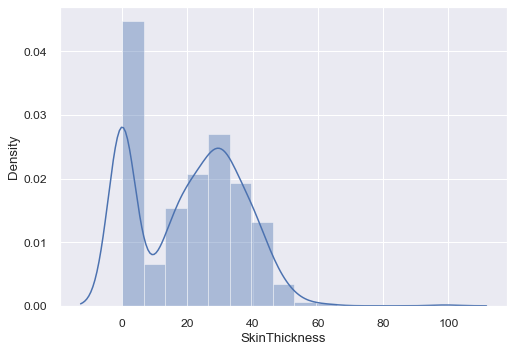

In [529]:
sns.distplot(df['SkinThickness']);

There are lots of zero values, indicating not measures or missing values!

In [530]:
df.loc[df.SkinThickness==0, :]   # 227 rows!

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
9,8,125,96,0,0,0.0,0.232,54,1
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
757,0,123,72,0,0,36.3,0.258,52,1
758,1,106,76,0,0,37.5,0.197,26,0
759,6,190,92,0,0,35.5,0.278,66,1
762,9,89,62,0,0,22.5,0.142,33,0


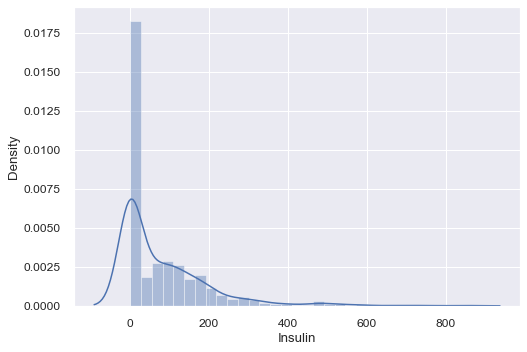

In [531]:
sns.distplot(df['Insulin']);

In [532]:
df.loc[df.Insulin == 0, :]   # 374 rows!

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


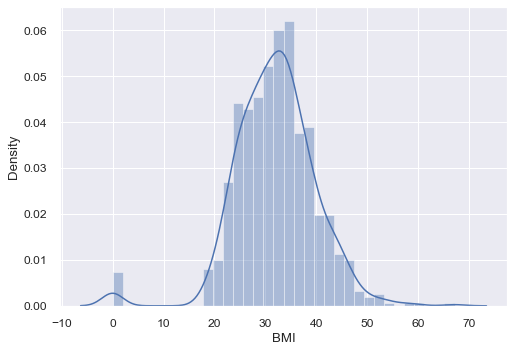

In [533]:
sns.distplot(df['BMI']);

In [534]:
df.loc[df.BMI == 0, :]   # 11 rows!

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


In [535]:
df.Glucose.median(), df.BloodPressure.median(), df.SkinThickness.median(), df.Insulin.median(), df.BMI.median()

(117.0, 72.0, 23.0, 30.5, 32.0)

In [536]:
median_glucose = df.Glucose.median()
df.loc[df.Glucose == 0, 'Glucose'] = median_glucose

In [537]:
median_bp = df.BloodPressure.median()
df.loc[df.BloodPressure == 0, 'BloodPressure'] = median_bp

In [538]:
median_skin_thickness = df.SkinThickness.median()
df.loc[df.SkinThickness == 0, 'SkinThickness'] = median_skin_thickness

In [539]:
median_insulin = df.Insulin.median()
df.loc[df.Insulin == 0, 'Insulin'] = median_insulin

In [540]:
median_bmi = df.BMI.median()
df.loc[df.BMI == 0, 'BMI'] = median_bmi

In [541]:
df.to_csv('./data/diabetes_mod.csv', index=False)

## Developing the model

In [542]:
df2 = pd.read_csv('./data/diabetes_mod.csv')
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,30.5,33.6,0.627,50,1
1,1,85,66,29,30.5,26.6,0.351,31,0
2,8,183,64,23,30.5,23.3,0.672,32,1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,1


In [543]:
def load_data(upsample=False, test_split=0.20):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    data_file = './data/diabetes_mod.csv'

    if not os.path.exists(data_file):
        print(f"Data file {data_file} does not exist!")
        return

    df = pd.read_csv(data_file)


    print(df.shape)
    print(df.head())

    # X = df.iloc[:, :-1].values
    # y = df.iloc[:, -1].values
    X = df.drop('Outcome', axis=1).values
    y = df['Outcome'].values

    print(f"Raw data shapes -> X.shape: {X.shape} - y.shape: {y.shape} - label dist: {np.bincount(y)}")

    # split into train/test sets
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_split, random_state=SEED, stratify=y)
    if upsample:
        difference = sum((y_train == 0) * 1) - sum((y_train == 1) * 1)
        indices = np.where(y_train == 1)[0]
        rand_subsample = np.random.randint(0, len(indices), (difference,))
        X_train = np.concatenate((X_train, X_train[indices[rand_subsample]]))
        y_train = np.concatenate((y_train, y_train[indices[rand_subsample]]))

    X_val, X_test, y_val, y_test = \
        train_test_split(X_test, y_test, test_size=test_split, random_state=SEED, stratify=y_test)

    # scale data
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)
    # y_train = np.expand_dims(y_train, axis=1)
    # y_val = np.expand_dims(y_val, axis=1)
    # y_test = np.expand_dims(y_test, axis=1)

    print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape}\n" +
          f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape}\n" +
          f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [544]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data()

(768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35     30.5  33.6   
1            1       85             66             29     30.5  26.6   
2            8      183             64             23     30.5  23.3   
3            1       89             66             23     94.0  28.1   
4            0      137             40             35    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Raw data shapes -> X.shape: (768, 8) - y.shape: (768,) - label dist: [500 268]
X_train.shape: (614, 8) - y_train.shape: (614,)
X_val.shape: (123, 8) - y_val.shape: (123,)
X_test.shape: (31, 8) - y_test.shape: (31,)


In [545]:
# Hyper-parameters
NUM_FEATURES = 8
NUM_CLASSES = 2
NUM_EPOCHS = 5000
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
DECAY = 0.01
MODEL_SAVE_PATH = './model_states/pyt_diabetes_ann.pt'

In [546]:
class PimaModel(pytk.PytkModule):
    def __init__(self):
        super(PimaModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 160),
            nn.ReLU(),
            #nn.Dropout(p=0.10),

            nn.Linear(160, 320),
            nn.ReLU(),
            #nn.Dropout(p=0.15),

            nn.Linear(320, 640),
            nn.ReLU(),
            # nn.Dropout(p=0.20),

            nn.Linear(640, NUM_CLASSES)
        )

    def forward(self, inp):
        x = self.net(inp)
        return x

In [547]:
def build_model():
    model = PimaModel()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=DECAY)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [548]:
model, optimizer = build_model()
print(model)

PimaModel(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=320, bias=True)
    (3): ReLU()
    (4): Linear(in_features=320, out_features=640, bias=True)
    (5): ReLU()
    (6): Linear(in_features=640, out_features=2, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [549]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                 epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, report_interval=100)

Training on CPU...
Training on 614 samples, cross-validating on 123 samples
NOTE: training progress will be reported after every 100 epochs
Epoch (   1/5000): (614/614) -> loss: 0.6958 - acc: 0.4120 - val_loss: 0.6929 - val_acc: 0.4491 - lr: ['0.00100000']
Epoch ( 100/5000): (614/614) -> loss: 0.5968 - acc: 0.6692 - val_loss: 0.6042 - val_acc: 0.6671 - lr: ['0.00100000']
Epoch ( 200/5000): (614/614) -> loss: 0.5456 - acc: 0.7195 - val_loss: 0.5534 - val_acc: 0.7052 - lr: ['0.00100000']
Epoch ( 300/5000): (614/614) -> loss: 0.5168 - acc: 0.7406 - val_loss: 0.5243 - val_acc: 0.7213 - lr: ['0.00100000']
Epoch ( 400/5000): (614/614) -> loss: 0.4983 - acc: 0.7523 - val_loss: 0.5073 - val_acc: 0.7317 - lr: ['0.00100000']
Epoch ( 500/5000): (614/614) -> loss: 0.4858 - acc: 0.7593 - val_loss: 0.4966 - val_acc: 0.7398 - lr: ['0.00100000']
Epoch ( 600/5000): (614/614) -> loss: 0.4764 - acc: 0.7646 - val_loss: 0.4894 - val_acc: 0.7465 - lr: ['0.00100000']
Epoch ( 700/5000): (614/614) -> loss: 0.4

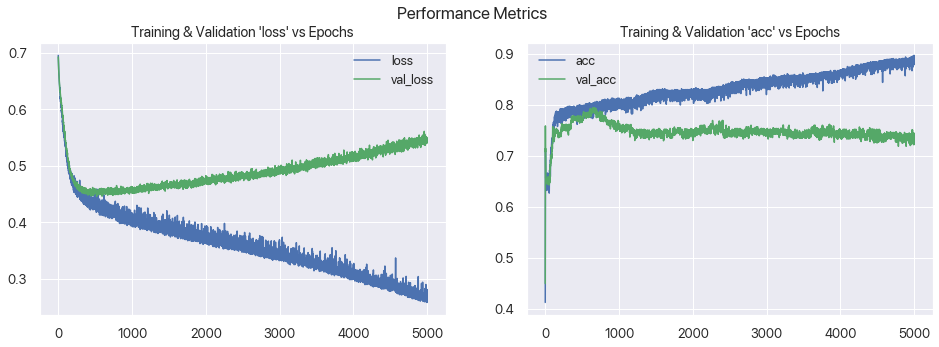

In [550]:
pytk.show_plots(hist, metric='acc', plot_title="Performance Metrics")

In [551]:
# evaluate model performance on train/eval & test datasets
print('\nEvaluating model performance...')
# loss, acc = model.evaluate_dataset(train_dataset)
loss, acc = model.evaluate(X_train, y_train)
print(f"  Training dataset  -> loss: {loss:.4f} - acc: {acc:.4f}")
# loss, acc = model.evaluate_dataset(val_dataset)
loss, acc = model.evaluate(X_val, y_val)
print(f"  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}")
# loss, acc = model.evaluate_dataset(test_dataset)
loss, acc = model.evaluate(X_test, y_test)
print(f"  Testing dataset   -> loss: {loss:.4f} - acc: {acc:.4f}")


Evaluating model performance...
Evaluating (614/614) -> loss: 0.2683 - acc: 0.8863
  Training dataset  -> loss: 0.2683 - acc: 0.8863
Evaluating (123/123) -> loss: 0.5393 - acc: 0.7264
  Cross-val dataset -> loss: 0.5393 - acc: 0.7264
Evaluating (31/31) -> loss: 0.5978 - acc: 0.7742
  Testing dataset   -> loss: 0.5978 - acc: 0.7742


In [552]:
# save model state
model.save(MODEL_SAVE_PATH)
del model

Pytorch model saved to ./model_states/pyt_diabetes_ann.pt


#### Observations
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---:|
>**Model**|85.17%|78.63%|72.28%| Overfitting

From the table & graphs we observe that:
* The model is significantly overfitting the data - `training accuracy >> cross-val accuracy`
* The training/cross-val loss plots start diverging significantly after the 3-4 th epoch itself
* The gap between `cross-val accuracy` and `test accuracy` is not that much (expected as the samples are drawn randomly from the same distribution)

In [553]:
print('\nRunning predictions...')
model, _ = build_model()
model.load(MODEL_SAVE_PATH)
print(model)


Running predictions...
Pytorch model loaded from ./model_states/pyt_diabetes_ann.pt
PimaModel(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=320, bias=True)
    (3): ReLU()
    (4): Linear(in_features=320, out_features=640, bias=True)
    (5): ReLU()
    (6): Linear(in_features=640, out_features=2, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [554]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# display output
print('Sample labels: ', y_test.flatten())
print('Sample predictions: ', y_pred)
print('We got %d/%d correct!' % ((y_test.flatten() == y_pred).sum(), len(y_test.flatten())))


Sample labels:  [0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0]
Sample predictions:  [0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0]
We got 24/31 correct!


In [555]:
del model

### Up-sampling the data

In [556]:
MODEL_SAVE_PATH2 = './model_states/pyt_diabetes_ann2.pt'

In [557]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data(upsample=True)

(768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35     30.5  33.6   
1            1       85             66             29     30.5  26.6   
2            8      183             64             23     30.5  23.3   
3            1       89             66             23     94.0  28.1   
4            0      137             40             35    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Raw data shapes -> X.shape: (768, 8) - y.shape: (768,) - label dist: [500 268]
X_train.shape: (800, 8) - y_train.shape: (800,)
X_val.shape: (123, 8) - y_val.shape: (123,)
X_test.shape: (31, 8) - y_test.shape: (31,)


In [558]:
model, optimizer = build_model()
print(model)

PimaModel(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=320, bias=True)
    (3): ReLU()
    (4): Linear(in_features=320, out_features=640, bias=True)
    (5): ReLU()
    (6): Linear(in_features=640, out_features=2, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [559]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                 epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, report_interval=100)

Training on CPU...
Training on 800 samples, cross-validating on 123 samples
NOTE: training progress will be reported after every 100 epochs
Epoch (   1/5000): (800/800) -> loss: 0.6880 - acc: 0.6000 - val_loss: 0.6817 - val_acc: 0.6950 - lr: ['0.00100000']
Epoch ( 100/5000): (800/800) -> loss: 0.6193 - acc: 0.7333 - val_loss: 0.6283 - val_acc: 0.7260 - lr: ['0.00100000']
Epoch ( 200/5000): (800/800) -> loss: 0.5678 - acc: 0.7350 - val_loss: 0.5792 - val_acc: 0.7202 - lr: ['0.00100000']
Epoch ( 300/5000): (800/800) -> loss: 0.5387 - acc: 0.7416 - val_loss: 0.5542 - val_acc: 0.7179 - lr: ['0.00100000']
Epoch ( 400/5000): (800/800) -> loss: 0.5196 - acc: 0.7493 - val_loss: 0.5400 - val_acc: 0.7155 - lr: ['0.00100000']
Epoch ( 500/5000): (800/800) -> loss: 0.5056 - acc: 0.7569 - val_loss: 0.5308 - val_acc: 0.7163 - lr: ['0.00100000']
Epoch ( 600/5000): (800/800) -> loss: 0.4947 - acc: 0.7625 - val_loss: 0.5243 - val_acc: 0.7185 - lr: ['0.00100000']
Epoch ( 700/5000): (800/800) -> loss: 0.4

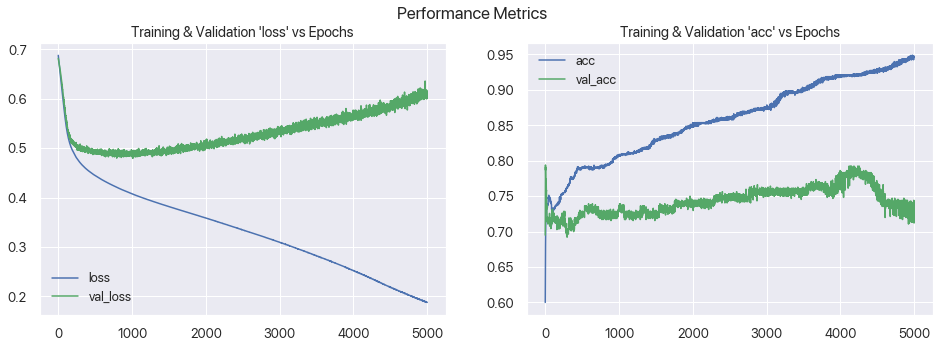

In [560]:
pytk.show_plots(hist, metric='acc', plot_title="Performance Metrics")

In [561]:
# evaluate model performance on train/eval & test datasets
print('\nEvaluating model performance...')
# loss, acc = model.evaluate_dataset(train_dataset)
loss, acc = model.evaluate(X_train, y_train)
print(f"  Training dataset  -> loss: {loss:.4f} - acc: {acc:.4f}")
# loss, acc = model.evaluate_dataset(val_dataset)
loss, acc = model.evaluate(X_val, y_val)
print(f"  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}")
# loss, acc = model.evaluate_dataset(test_dataset)
loss, acc = model.evaluate(X_test, y_test)
print(f"  Testing dataset   -> loss: {loss:.4f} - acc: {acc:.4f}")


Evaluating model performance...
Evaluating (800/800) -> loss: 0.1833 - acc: 0.9447
  Training dataset  -> loss: 0.1833 - acc: 0.9447
Evaluating (123/123) -> loss: 0.6041 - acc: 0.7427
  Cross-val dataset -> loss: 0.6041 - acc: 0.7427
Evaluating (31/31) -> loss: 0.7057 - acc: 0.7742
  Testing dataset   -> loss: 0.7057 - acc: 0.7742


In [562]:
# save model state
model.save(MODEL_SAVE_PATH)
del model


Pytorch model saved to ./model_states/pyt_diabetes_ann.pt


#### Observations
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---:|
>**Model**|85.17%|78.63%|72.28%| Overfitting
>**Model**|87.50%|81.25%|71.75%| Overfitting & worse

From the table & graphs we observe that:
* The model is significantly overfitting the data - `training accuracy >> cross-val accuracy`
* The training/cross-val loss plots start diverging significantly after the 3-4 th epoch itself
* The gap between `cross-val accuracy` and `test accuracy` is not that much (expected as the samples are drawn randomly from the same distribution)

In [563]:
print('\nRunning predictions...')
model, _ = build_model()
model.load(MODEL_SAVE_PATH)
print(model)


Running predictions...
Pytorch model loaded from ./model_states/pyt_diabetes_ann.pt
PimaModel(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=320, bias=True)
    (3): ReLU()
    (4): Linear(in_features=320, out_features=640, bias=True)
    (5): ReLU()
    (6): Linear(in_features=640, out_features=2, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [564]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# display output
print('Sample labels: ', y_test.flatten())
print('Sample predictions: ', y_pred)
print('We got %d/%d correct!' % ((y_test.flatten() == y_pred).sum(), len(y_test.flatten())))


Sample labels:  [0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0]
Sample predictions:  [0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0]
We got 24/31 correct!


In [565]:
del model